In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# **Practice with Python, Pandas + Sklearn: Features and How-Tos**

<img src='https://la-community-cdn.linuxacademy.com/img/user_23708_5849f32880efa.jpg' style='width:500px' />

Greetings all! The goal of this guide is to show off the tools and options available under the pandas and sk learn library. Instead of looking at small 3x3 matrix toy examples, thought it would be good to compile all of the functions with a regular dataset. The Iowa dataset is relatable, the sale price of houses are somewhat inituitve, and all the data can fit locally on the computer.  

This will be a **growing document**, so this initial post only covers basic data ingestion and manipulation. If any of you have found some neat tricks, or good libraries for getting around data science, feel free to comment and Ill make the update! Hope those of you that are just getting started will find the walkthrough helpful!


### **Version Notes:**
- 3: Added detail about classification scoring, how to get predictions out of your model, and overview of loss functions
- 2: Added additional word documentation, some pandas creation notes and formatting 
- 1: Inital Post

## **Topics:**
### **1. [Load your Libraries](#section1)**
### **2. [Navigating with Pandas](#section2)**
### **3. [Cleaning your data](#section3)**
### **4. [Feature Engineering](#section4)**
### **5. [Model Prep: train, test and split](#section5)**
### **6. [Modeling: Linear Regression, Logistic Regression, Random Forests](#section6)**
### **7. [Quest for the best parameters](#section7)**
### **8. [Scores, Loss, and whats under the hood](#section8)**


### ** Problem: How much does a house cost? What makes it that expensive?**
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

The dataset we will be using was compiled by Dean De Cock, and "This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory 
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home 
values"

* Check out his paper here: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf 
![](http://www.hubbellhomes.com/images/community/368/tb/Pemberley-Hills-thumbNEW.jpg)

# **Before we get started: Beginners Tips**

<img src='http://www.allwebdesigninfo.com/wp-content/uploads/2014/03/Beginner-Programming-Mistakes.jpg'  width='400px' />

### **Choose good Words for your Variables. Keep track of them!** 
For long analysis, becareful how you name your variables. With really complicated notebooks, a simple rewrite can ruin the rest of your programming setup. especially becareful of these keywords:

**` X, y, n, df, data, dataframe, train, test, results, final_results, predict` **
Just know up front that you will most likely be using these words. Becareful of using these variables elsewhere in coding loops etc.. Every one is taught using `a`, `b`, `x`, `y`,`z` in loops and lists. 

In data science:
- **`X`** usually refers to a **dataframe** of source data in which we will use to make a prediction. 
- **`y`** usually refers to the thing we are trying to predict, either money, or 1 / 0 if someone has a disease. 
- **`test`** should not be the function you are prototyping, this too represents a **dataframe** of records that are used for evaluating our work. Name that new funcion you are writing something like `foobar` or `mygreatfunc`

```python
    # currently y is a matrix
    y,X = train_test_split(mydf)

    ## now, y is a temp variable in a loop
    for y in list_of_columns:
        print('column named' + y)

    ## what the heck is in 'y' now?
    model.fit(X,y)
    ```
    
  
### **Becareful of Self-Assignment of Vars (a = a +1 ) ** 
As you are going on, running through your python notebooks, you will be running chunks of code. Becareful of reusing names and looping coding blocks,  code lines are divided between different blocks. 

A standalone block where you do a self-assignment AKA variable name is reused, can lead to a recursive like effects. See below

```python
    # this is fine because the data is reloaded, each time this block is run
    mydf = load_data()
    mydf = replace_any_zeroes(df)
```

```python
    # left join will add columns on the right side of your data frame. if you keep re-running this block, it will continously append new columns over and over with no end, your dataframe will keep growing horizontally!
    mydf = mydf.left_join(new_dataset)
    my_counter = my_counter + 1
```


 ### **Pandas Warning on DataFrame copying** 
 
 Pandas dataframes as they get manipulated for a majority of the time are still referencing the same memory or dataframe:
 
```python

# IS STILL POINTING TO ORIGINAL, EDITS TO NEW WILL ALSO BE APPLIED TO ORIGINAL
new_df = master_df 

new_df[ 1,2 ] = b # will also update `master_df` as well. Careful!

# makes a new copy to avoid this issue
new_df = df.copy()
```



<a id='section1'></a>
# **1. Load Your Data, Load your Libraries**

Well, lets get started loading a bunch of libraries that we will be showing off with the data

<img src='https://ak8.picdn.net/shutterstock/videos/17983978/thumb/7.jpg' style='width:300px'/>

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

#prep
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

#models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#validation libraries
from sklearn.cross_validation import KFold, StratifiedKFold
from IPython.display import display
from sklearn import metrics


%matplotlib inline

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a id='section2'></a>
# **2. Navigating your data**
The following section is a primer for loading data into **dataframes** which are essentially very powerful data grids that have a lot of great functionality for manipulating data. These can also be thought of as super powerful excel sheets. Below we will show some basic syntax usage of getting around your dataframe. 

<img src='https://www.eurisy.org/data_files/mce_images/Blog_images/Human_hand_with_a_laptop_surrounded_by_iconsellagrin.jpg' style='width:400px' />
#### Dataset size

- **Train**: 1460
- **Test**: 1458

### **reading in CSV's from a file path**

In [4]:
train_df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### **Making a pandas dataframe from either a list or a dictionary**
<img src='https://snag.gy/toRSjY.jpg' />
<img src='http://pbpython.com/images/pandas-dataframe-shadow.png' />

Often times we don't have a CSV available, but the data comes from a database or another python program. This nifty reference shows how we can make a dataframe from python's common **`list`** or **`dict`** objects

In [5]:
# here's one sample
sample_dict = [
    {'label': 'house i would like', 'sqft':5000},
    {'label': 'house i would hate','sqft':500},
    {'label': 'house i live in', 'sqft':800}
]
pd.DataFrame(sample_dict)

,label,sqft
0,house i would like,5000
1,house i would hate,500
2,house i live in,800


### **Pandas: whats the data row count?**

In [6]:
train_df.shape

(1460, 81)

### ** Pandas: whats the distribution of the data?**

In [7]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### **Pandas: What types of data do i have?**

The main data types for pandas dataframes are 
- **in64** - whole numbers
- **float** - decimals 
- **object** - most general type, mixed numbers and letters
- **category** - assigned labels such as [small, medium, large]
- **datetime**

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### **Filtering and Peering inside the dataframe**

<img src='http://www.blastam.com/wp-content/uploads/ecommerce-filter-feature.jpg' />

#### ** Pandas: take a peek at the first few rows,  note what may be categorical , what may be numeric**

In [9]:
train_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## **When is it an array? When is it a Dataframe?, note the difference `[ ]` vs `[[ ]]`**
<img src='http://venus.ifca.unican.es/Rintro/_images/dataStructuresNew.png' style='width:400px'>
- An **vector** is a 1-D collection, either a `list`, a `set`, `numpy.array`, or even a `pandas.series` 
- A **matrix** is typically a 2-D collection of rows and columns such as a nested `list`, a `numpy.array` or a `pandas.DataFrame`
- When working with **DataFrames** and matrices, there's a lot of methods to convert one to the other:
        - `pandas.DataFrame.asmatrix()`
        - `pandas.DataFrame.to_dense()`


In [10]:
train_df['SalePrice'].head(5)

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [11]:
train_df[['SalePrice']].head(5)

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [12]:
train_df.as_matrix()

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array([[1, 60, 'RL', ..., 'WD', 'Normal', 208500],
       [2, 20, 'RL', ..., 'WD', 'Normal', 181500],
       [3, 60, 'RL', ..., 'WD', 'Normal', 223500],
       ...,
       [1458, 70, 'RL', ..., 'WD', 'Normal', 266500],
       [1459, 20, 'RL', ..., 'WD', 'Normal', 142125],
       [1460, 20, 'RL', ..., 'WD', 'Normal', 147500]], dtype=object)

In [13]:
pd.DataFrame(train_df.as_matrix()).head()

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### **Pandas: Filtering  and slicing your dataframe**

<img src='http://bookdata.readthedocs.io/en/latest/_images/base_01_pandas_5_0.png' style='width:400px' />

In [14]:
train_df[['SalePrice','LotShape']].head(4)

,SalePrice,LotShape
0,208500,Reg
1,181500,Reg
2,223500,IR1
3,140000,IR1


In [15]:
train_df.iloc[range(3),]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [16]:
train_df[train_df['SalePrice']>200000].head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
train_df[train_df['LotShape'].isin(['Reg','IR1'])].head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### **Pandas: Take a look at the column names of all the fields**

In [18]:
print('this many columns:%d ' % len(train_df.columns))
train_df.columns

this many columns:81 


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### **Changing the Column names starting with numbers , later functions sometimes have issues**

In [19]:
train_df.columns = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirsstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']

<a id='section3'></a>
# **3. Clean your Data**
<img src='https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAALAAAAAJGU3YjAwY2I5LTg1ODMtNDg5Ny04MTg2LTNhMWUwYTdkZDk2Zg.png'  width='300px'/>****

### **Check for Blanks or NA's!**

Note that there is a difference between **`NaN`, `''`, `None`** so be aware when looking at your data
- **`NaN`** = not a number, still a `float` type, so think of it of empty space that can still be passed through numerical operations
- **`''`** = is a empty string type
- **`None`** = is also a empty space, but in DataFrames it is considered an `object` which cannot be processed through optimized numerical operations

#### **Pandas: Check for NA's in a column**

In [20]:
train_df[train_df['Alley'].isnull()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


### **Pandas: Fill in NA's**

<img src='http://csharpcorner.mindcrackerinc.netdna-cdn.com/UploadFile/219d4d/different-ways-to-replace-null-in-sql-server/Images/records.jpg'/>

The `fillna` function is much handier to fill in NA's that trying to the boolean. If needed you can do a comparison with `numpy.NaN` or in our case `==np.nan`, `np.isnan(some number )`

In [21]:
train_df['Alley'].fillna(0, inplace=True)

In [175]:
na_totals = train_df.isnull().sum().sort_values(ascending=False)
na_totals[na_totals>0]

Series([], dtype: int64)

In [23]:
train_df.fillna(0, inplace=True)

## **Categorical vs. Continuous**
<img src='https://i.ytimg.com/vi/7bsNWq2A5gI/hqdefault.jpg' />

When looking at your data, its important to understand the nature of the data. If you had $1000 vs. $2000 is there such thing as $1556 dollars? Yes, of course. But between a 1 and 2 story house, is there such a thing as a 2.33 story house? Good model design always starts with good data understand and decisions on how each cell should be treated.

#### **Best Practice: Check and Assign numerical features**



Identified square area as numeric. Identified any field that had that aspect to them

In [180]:
numeric_col = [x for x in train_df.columns if ('Area' in x) | ('SF' in x)] + ['SalePrice','LotFrontage','MiscVal','EnclosedPorch','ThreeSsnPorch','ScreenPorch','OverallQual','OverallCond','YearBuilt']
numeric_col

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'FirsstFlrSF',
 'SecondFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'LivArea_Total',
 'LotArea_norm',
 'LotArea_mas',
 'LotArea_qs',
 'SalePrice',
 'LotFrontage',
 'MiscVal',
 'EnclosedPorch',
 'ThreeSsnPorch',
 'ScreenPorch',
 'OverallQual',
 'OverallCond',
 'YearBuilt']

In [177]:
numeric_cols = [x for x in train_df.columns if ('Area' in x) | ('SF' in x)] + ['SalePrice','LotFrontage','MiscVal','EnclosedPorch','ThreeSsnPorch','ScreenPorch','OverallQual','OverallCond','YearBuilt']

for col in numeric_cols:
    train_df[col] = train_df[col].astype(float)
numeric_cols

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'FirsstFlrSF',
 'SecondFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'LivArea_Total',
 'LotArea_norm',
 'LotArea_mas',
 'LotArea_qs',
 'SalePrice',
 'LotFrontage',
 'MiscVal',
 'EnclosedPorch',
 'ThreeSsnPorch',
 'ScreenPorch',
 'OverallQual',
 'OverallCond',
 'YearBuilt']

#### **Best Practice: Check and Convert the rest into categorical**

In [26]:
categorical_cols = [x for x in train_df.columns if x not in numeric_cols]

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')

<a id='section4'></a>
# **4. Feature engineering**

<img src='https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAAiuAAAAJGRkNGQzNjU5LTQzOTAtNDRlZC05NTZkLTcxZWM5YmYwZmRkNA.png' style='width:300px'>

### **Pandas: How to transform a column / apply a function against it**
In this case we will be looking at Log sale price. Here's how to transform a column. Both ways are valid, but the 2nd method only works because `np.log` was designed for handling vectors. If you tried 

`df['full name'] = df['first name'] + df['last name']` it will not work with this approach because there is no + operator that concats two vectors elementwise.

### **Create calculated fields from other features (2 ways outlined below)**

<img src='https://snag.gy/sQa5qS.jpg' />

1. Use the `.map( func )` or  `.apply(func, axis )` functions to element-wise apply a function
2. Assign the either column with another vector , or vectorized operations

In [30]:
## Applying an element wise function
train_df['LogSalePrice'] = train_df['SalePrice'].map(lambda x : np.log(x)) 

#Vectorized log function acting on a vector
# then assigning all the values at once
train_df['LogSalePrice'] = np.log(train_df['SalePrice'])

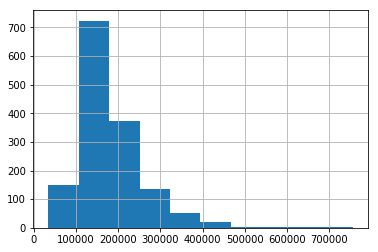

In [31]:
train_df['SalePrice'].hist()

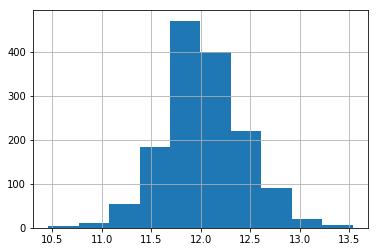

In [33]:
train_df['LogSalePrice'].hist()

In [34]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450.0,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0.0,2,2008,WD,Normal,208500.0,12.247694
1,2,20,RL,80.0,9600.0,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0.0,5,2007,WD,Normal,181500.0,12.109011
2,3,60,RL,68.0,11250.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0.0,9,2008,WD,Normal,223500.0,12.317167
3,4,70,RL,60.0,9550.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0.0,2,2006,WD,Abnorml,140000.0,11.849398
4,5,60,RL,84.0,14260.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0.0,12,2008,WD,Normal,250000.0,12.429216


### **Python, how to make a continuous variable categorical? (2 ways)**

<img src='https://snag.gy/sIBulc.jpg' />

In [36]:
# element wise function to transform
train_df['above_200k'] = train_df['SalePrice'].map(lambda x : 1 if x > 200000 else 0) 
train_df['above_200k'] = train_df['above_200k'].astype('category')

In [37]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice,above_200k
0,1,60,RL,65.0,8450.0,Pave,0,Reg,Lvl,AllPub,...,0,0,0.0,2,2008,WD,Normal,208500.0,12.247694,1
1,2,20,RL,80.0,9600.0,Pave,0,Reg,Lvl,AllPub,...,0,0,0.0,5,2007,WD,Normal,181500.0,12.109011,0
2,3,60,RL,68.0,11250.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0.0,9,2008,WD,Normal,223500.0,12.317167,1
3,4,70,RL,60.0,9550.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0.0,2,2006,WD,Abnorml,140000.0,11.849398,0
4,5,60,RL,84.0,14260.0,Pave,0,IR1,Lvl,AllPub,...,0,0,0.0,12,2008,WD,Normal,250000.0,12.429216,1


or

In [ ]:
# manually assign the values to your new field, section by section
# with row filtering
train_df.loc[train_df['SalePrice']>200000,'above_200k'] = 1
train_df.loc[train_df['SalePrice']<=200000,'above_200k'] = 0
train_df['above_200k'] = train_df['above_200k'].astype('category')

 ### **Pandas: how to add columns together (numeric)**

In [40]:
train_df.columns.sort_values(ascending = True)

Index(['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir',
       'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond',
       'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu',
       'Fireplaces', 'FirsstFlrSF', 'Foundation', 'FullBath', 'Functional',
       'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating',
       'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual',
       'LandContour', 'LandSlope', 'LogSalePrice', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [41]:
train_df['LivArea_Total'] = train_df['GrLivArea'] + train_df['GarageArea'] + train_df['PoolArea']
train_df[['LivArea_Total','GrLivArea','GarageArea','PoolArea']].head()

,LivArea_Total,GrLivArea,GarageArea,PoolArea
0,2258.0,1710.0,548.0,0.0
1,1722.0,1262.0,460.0,0.0
2,2394.0,1786.0,608.0,0.0
3,2359.0,1717.0,642.0,0.0
4,3034.0,2198.0,836.0,0.0


### **Pandas: how to apply a function row - wise (example is adding strings)**

- `axis=0` - pass a **column** of data
- `axis=1` - pass a **row** of data

In [42]:
## concatenating two different fields together in the same row
train_df['Lot_desc'] = train_df.apply(lambda val : val['MSZoning'] + val['LotShape'], axis=1)
train_df[['Lot_desc','MSZoning','LotShape']].head()

,Lot_desc,MSZoning,LotShape
0,RLReg,RL,Reg
1,RLReg,RL,Reg
2,RLIR1,RL,IR1
3,RLIR1,RL,IR1
4,RLIR1,RL,IR1


## **Sklearn: How to scale fields**

For some of the models, comparing a field such as years old vs. square footage will have vastly different scales. Years old will vary from **0-30** and square footage will vary from **500-4000**, as a result, some models will have a difficult time or take much longer to find an optimal solution. As a result, there are a number of tools provided to assist with **normalizing** your data
<img src='http://images.slideplayer.com/38/10783489/slides/slide_36.jpg' style='width:500px'/>

- `StandardScaler` - subtract the mean and divide by std
- `MaxAbsScaler` - transform down to [-1, 1] bounds
- `QuantileTransformer` - transform down to [0 1] bounds

## **Word to the wise: `fit` vs. `fit_transform` vs. `transform`**

`fit_transform`
**$$X_{train-norm} =\frac{ X_{train} - \mu_{train} }{\sigma_{train}}$$**

`transform` - note that we divide by the previously fit values
**$$X_{test-norm} =\frac{ X_{test} - \mu_{train} }{\sigma_{train}}$$**

- **`fit`** - when you fit a scaler to dataset A, it calculates mean of A, and the standard deviation of A
- **`transform`** - this will actually look at ANY dataset and subtract previously fitted (calculated) variables mean A and divide by standard deviation of A
**`fit_transform`** does both of these things in two steps.

#### **For consistency purposes, it is best to `fit_transform` on your training dataset, but only `transform` your validation set. This ensures your validation and training set has been  consistently transformed**



In [43]:
train_df['LotArea_norm'] = train_df['LotArea']

ss = StandardScaler()
mas = MaxAbsScaler()
qs = QuantileTransformer()

train_df['LotArea_norm'] = ss.fit_transform(train_df[['LotArea']])
train_df['LotArea_mas'] = mas.fit_transform(train_df[['LotArea']])
train_df['LotArea_qs'] = qs.fit_transform(train_df[['LotArea']])


train_df[['LotArea_norm','LotArea_mas','LotArea_qs', 'LotArea']].head(5)

,LotArea_norm,LotArea_mas,LotArea_qs,LotArea
0,-0.207142,0.039258,0.349349,8450.0
1,-0.091886,0.044600,0.525025,9600.0
2,0.073480,0.052266,0.720220,11250.0
3,-0.096897,0.044368,0.509667,9550.0
4,0.375148,0.066250,0.897123,14260.0


## **Words/Labels as Features**

<img src='https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eg2_new_4.png' />

How does a computer deal with words or labels? A computer doesn't know "red car" vs. "blue car", instead they represent say `color` with a field called `is_it_red` filled with `0`'s and `1`'s. All of these word labels are represented this way in the dataframe. But what if there's more than 2 options ? If there's multiple **labels**, we have the following options: 


### **Sklearn: 1 hot encoding  Method ((a column for every label, left table in pic)**
<img src='https://cdn-images-1.medium.com/max/1600/1*ZsYkXEa1qrKeGiplNnFHyQ.jpeg' width='500px' />

We know that MSSubclass is a categorical, lets turn it into 1 hot encoding. Note if you pass your entire dataframe, it will convert all of it AUTOMATICALLY. 

#### **If you want to do this piece meal, isolate the single target categorical column, transform it and join it back together**

In [51]:
small_df = train_df[['MSZoning','SalePrice']].copy()
small_df['MSZoning'] = small_df['MSZoning'].astype('category')
small_df.head()

,MSZoning,SalePrice
0,RL,208500.0
1,RL,181500.0
2,RL,223500.0
3,RL,140000.0
4,RL,250000.0


In [45]:
pd.get_dummies(small_df).head(5)

,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,208500.0,0,0,0,1,0
1,181500.0,0,0,0,1,0
2,223500.0,0,0,0,1,0
3,140000.0,0,0,0,1,0
4,250000.0,0,0,0,1,0


### **Sklearn: Label Encoding Method ( multiple int options, but 1 column, right table in pic)**
<img src='https://cdn-images-1.medium.com/max/1600/1*ZsYkXEa1qrKeGiplNnFHyQ.jpeg' width='500px' />


In [50]:
small_df = train_df[['MSSubClass','SalePrice']].copy()
small_df['MSSubClass'] = small_df['MSSubClass'].astype('category')
small_df.head()

,MSSubClass,SalePrice
0,60,208500.0
1,20,181500.0
2,60,223500.0
3,70,140000.0
4,60,250000.0


In [47]:
le = LabelEncoder()
trf_MSSubClass = le.fit_transform(small_df['MSSubClass'])
trf_MSSubClass

array([5, 0, 5, ..., 6, 0, 0], dtype=int64)

In [48]:
le.classes_

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190], dtype=int64)

In [49]:
le.inverse_transform(trf_MSSubClass)

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([60, 20, 60, ..., 70, 20, 20], dtype=int64)

<a id='section5'></a> 
## **5. Model Prep! Splitting DataFrames by Columns with 2 methods**

<img src='http://okfnlabs.org/img/posts/olap-slice_and_dice-overview.png' style='width:400px' />

The general structure that any model will follow is outlined as below:

>**`what im predicting(cols) = some_function ( collected_data(cols) )`**

This is often described in the following two ways:

>**`response = some_model( features )`**

>**`target = some_model( features )`**

>**`dependent variables = some_model( independent variables )`**

Or borrowing from the statistics world:

>**`y = some_model(X)`**

To split out these two different components that we need, we will need to **split up our dataframe into y, X, or our (target, features)**



In [52]:
feature_cols = [col for col in train_df.columns if 'Price' not in col]

In [65]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,LogSalePrice,above_200k,LivArea_Total,Lot_desc,LotArea_norm,LotArea_mas,LotArea_qs
0,1,60,RL,65.0,8450.0,Pave,0,Reg,Lvl,AllPub,...,WD,Normal,208500.0,12.247694,1,2258.0,RLReg,-0.207142,0.039258,0.349349
1,2,20,RL,80.0,9600.0,Pave,0,Reg,Lvl,AllPub,...,WD,Normal,181500.0,12.109011,0,1722.0,RLReg,-0.091886,0.044600,0.525025
2,3,60,RL,68.0,11250.0,Pave,0,IR1,Lvl,AllPub,...,WD,Normal,223500.0,12.317167,1,2394.0,RLIR1,0.073480,0.052266,0.720220
3,4,70,RL,60.0,9550.0,Pave,0,IR1,Lvl,AllPub,...,WD,Abnorml,140000.0,11.849398,0,2359.0,RLIR1,-0.096897,0.044368,0.509667
4,5,60,RL,84.0,14260.0,Pave,0,IR1,Lvl,AllPub,...,WD,Normal,250000.0,12.429216,1,3034.0,RLIR1,0.375148,0.066250,0.897123


### **Method 1 manually use dataframe methods to split X and y**

In [73]:
y = train_df['LogSalePrice']
X = train_df[feature_cols]

In [74]:
X.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,above_200k,LivArea_Total,Lot_desc,LotArea_norm,LotArea_mas,LotArea_qs
0,1,60,RL,65.0,8450.0,Pave,0,Reg,Lvl,AllPub,...,2,2008,WD,Normal,1,2258.0,RLReg,-0.207142,0.039258,0.349349
1,2,20,RL,80.0,9600.0,Pave,0,Reg,Lvl,AllPub,...,5,2007,WD,Normal,0,1722.0,RLReg,-0.091886,0.044600,0.525025


In [75]:
y.head(2)

0    12.247694
1    12.109011
Name: LogSalePrice, dtype: float64

### **Method 1b: Quick and Dirty way to get 100% numerical matrix (swap categories to numbers)**

In [89]:
pd.options.display.max_columns = 20

In [90]:
X_numerical = pd.get_dummies(X)
X_numerical.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Lot_desc_RHIR2,Lot_desc_RHReg,Lot_desc_RLIR1,Lot_desc_RLIR2,Lot_desc_RLIR3,Lot_desc_RLReg,Lot_desc_RMIR1,Lot_desc_RMIR2,Lot_desc_RMIR3,Lot_desc_RMReg
0,65.0,8450.0,7.0,5.0,2003.0,196.0,706.0,0.0,150.0,856.0,...,0,0,0,0,0,1,0,0,0,0
1,80.0,9600.0,6.0,8.0,1976.0,0.0,978.0,0.0,284.0,1262.0,...,0,0,0,0,0,1,0,0,0,0
2,68.0,11250.0,7.0,5.0,2001.0,162.0,486.0,0.0,434.0,920.0,...,0,0,1,0,0,0,0,0,0,0
3,60.0,9550.0,7.0,5.0,1915.0,0.0,216.0,0.0,540.0,756.0,...,0,0,1,0,0,0,0,0,0,0
4,84.0,14260.0,8.0,5.0,2000.0,350.0,655.0,0.0,490.0,1145.0,...,0,0,1,0,0,0,0,0,0,0


In [88]:
X_numerical.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'Lot_desc_RHIR2', 'Lot_desc_RHReg', 'Lot_desc_RLIR1', 'Lot_desc_RLIR2',
       'Lot_desc_RLIR3', 'Lot_desc_RLReg', 'Lot_desc_RMIR1', 'Lot_desc_RMIR2',
       'Lot_desc_RMIR3', 'Lot_desc_RMReg'],
      dtype='object', length=2010)

### **Method 2: With Patsy, using R-like formulas to split the dataframe**

For more information on R like formulas, see the documentation below
https://patsy.readthedocs.io/en/latest/formulas.html

Examples:
- ` SalePrice ~ GrLivArea + RmsAboveGrd` 
    - `y` is the sale price
    - `X` will have general living area and # of rooms above ground
- ` GrLivArea ~ PorchArea + PoolArea`
    - `y` is the general living area
    - `X` will be the porch area and pool area

In [96]:
import patsy
formula = 'LogSalePrice ~ %s' % (' + '.join(feature_cols)) 
y, X = patsy.dmatrices(formula, train_df, return_type='dataframe')
print(y.head(2),'\n\n', X.head(2))

   LogSalePrice
0     12.247694
1     12.109011 

    Intercept  Id[T.2]  Id[T.3]  Id[T.4]  Id[T.5]  Id[T.6]  Id[T.7]  Id[T.8]  \
0        1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1        1.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Id[T.9]  Id[T.10]     ...      OpenPorchSF  EnclosedPorch  ThreeSsnPorch  \
0      0.0       0.0     ...             61.0            0.0            0.0   
1      0.0       0.0     ...              0.0            0.0            0.0   

   ScreenPorch  PoolArea  MiscVal  LivArea_Total  LotArea_norm  LotArea_mas  \
0          0.0       0.0      0.0         2258.0     -0.207142     0.039258   
1          0.0       0.0      0.0         1722.0     -0.091886     0.044600   

   LotArea_qs  
0    0.349349  
1    0.525025  

[2 rows x 1951 columns]


In [103]:
pd.options.display.max_columns = 50

In [104]:
X.head(2)

,Intercept,Id[T.2],Id[T.3],Id[T.4],Id[T.5],Id[T.6],Id[T.7],Id[T.8],Id[T.9],Id[T.10],Id[T.11],Id[T.12],Id[T.13],Id[T.14],Id[T.15],Id[T.16],Id[T.17],Id[T.18],Id[T.19],Id[T.20],Id[T.21],Id[T.22],Id[T.23],Id[T.24],Id[T.25],...,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirsstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,LivArea_Total,LotArea_norm,LotArea_mas,LotArea_qs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8450.0,7.0,5.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2258.0,-0.207142,0.039258,0.349349
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9600.0,6.0,8.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,1722.0,-0.091886,0.044600,0.525025


In [102]:
y.head(2)

,LogSalePrice
0,12.247694
1,12.109011


## **Train Test Split: how to grade your model**

<img src='https://cdn-images-1.medium.com/max/948/1*4G__SV580CxFj78o9yUXuQ.png' width='400px'/>

Some vocabulary:

|Terms | Description | variables | Analogy |
|----|-------|----|---|
|Training Rows | This the data that the model will use to learn patterns and find an optimal solution| X_train, y_train| These are old exams a student might study repeatedly
|Validation Rows - Dev Set | Once the model is completed, this is the data that the model hasn't seen, and will be used to score the model. This tests how "general" the model is, by seeing its performance with unseen data | X_val, y_val| These are old exams a student will only take once or twice as a diagnostic
| Test set | this data is usually just the independent variables, and may or may not have the response. This is  data we actually need predictions for | X_test | This is the real exam.

So in short:

- **`train`** will use this to find optimal models, can be checked for performance, but more for a gut-check and troubleshooting
- **`valid`** will use this dataset to determine the model's performance and robustness

So to create these different row subsets, we will outline the following methods. 


### **Method 1 - split out different rowsets manually with indexing**

In [115]:
len(X)

1460

In [119]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 170
n_trn = len(y)-n_valid
print('n_trn = ', n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


n_trn =  1290
(1290, 1951) (170, 1951) (1290, 1) (170, 1)


### **Method 2 - split out rowsets using sklearn's train_test split function**
> 

In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(1168, 1951) (292, 1951) (1168, 1) (292, 1)


<a id='section6'></a>
# **6. Modeling - An Overview of Linear Model, Regularized Model, and Random Forest**
<img src='https://www.lintao-dashboards.com/wp-content/uploads/2016/02/ldm930.jpg' style='width:400px' />


## ** Regression** 
<img src='https://i.stack.imgur.com/SbqXz.png' style='width:400px' />

**Wikipedia:** In statistics, linear regression is a linear approach for modeling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.

**Caveat:** We are assuming that the relationship is linear. If we are modeling something like compound interest for a savings account, then fitting a linear model is not appropriate. 

### **Fitting a Linear Model**

In [120]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
lm.score(X_train,y_train)

1.0

In [122]:
lm.score(X_valid,y_valid)

0.7257779312662443

In [123]:
y_pred = lm.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.20744703023417752

### **Fitting a regularized linear Model (with k Folds)**

<img src='https://onlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson04/ridge_regression_geomteric.png' style='width:400px' />

**What do you do if you have a lot of variables?** As nice as plotting is, if there's 100's of other columns to compare to, it can be very difficult. Regularization is a mathy approach deal with some of these issues, helping with collinear (related) columns and also helping with variable selection.

In [124]:
rdgCV = RidgeCV(alphas=[0.01,0.1,1,10,100,1000], cv=5)
rdgCV.fit(X_train,y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [125]:
print(rdgCV.alpha_)

10


In [126]:
rdg = Ridge(alpha=10)
rdg.fit(X_train, y_train)
rdg.score(X_valid, y_valid)

0.73577105360861

In [127]:
y_pred = rdg.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.20363208921591294

### **Fitting a RandomForest Regressor**

<img src='https://d2wh20haedxe3f.cloudfront.net/sites/default/files/random_forest_diagram_complete.png' style='width:400px' />


* #### **Parameters**:

**`df`**: The data frame you wish to process.

**`y_fld`**: The name of the response variable

**`skip_flds`**: A list of fields that dropped from df.

**`do_scale`**: Standardizes each column in df.

**`na_dict`**: a dictionary of na columns to add. Na columns are also added if there
    are any missing values.

**`preproc_fn`**: A function that gets applied to df.

**`max_n_cat`**: The maximum number of categories to break into dummy values, instead
    of integer codes.

**subset**: Takes a random subset of size subset from df.

#### Returns:
**`[x, y, nas]`**:
    
   **`x`**: x is the transformed version of df. x will not have the response variable
        and is entirely numeric.

   **`y`**: y is the response variable

   **nas**: returns a dictionary of which nas it created, and the associated median.


In [128]:
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfr.fit(X,y)

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [129]:
rfr.score(X_valid,y_valid)

0.9872058949407367

In [130]:
y_pred = rfr.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.04480855891657072

## **Classification**

### **Fitting a Logistic Regression**

<img src='https://i1.wp.com/dataaspirant.com/wp-content/uploads/2016/04/logisticregression.png' style='width:600px' />
#### **Resplitting data for categorical prediction**

In [133]:
import patsy

train_df['above_200k'] = train_df['above_200k'].astype(float)
formula = 'above_200k ~ %s' % (' + '.join(feature_cols)) 
y_cls, X_cls = patsy.dmatrices(formula, train_df, return_type='dataframe')
# print(y.head(2),'\n\n', X.head(2))


X_cls_train, X_cls_valid, y_cls_train, y_cls_valid = train_test_split(X_cls,y_cls, test_size=0.2)
print(X_cls_train.shape, X_cls_valid.shape, y_cls_train.shape, y_valid.shape)

(1168, 1951) (292, 1951) (1168, 1) (170, 1)


In [136]:
X.head(2)

,Intercept,Id[T.2],Id[T.3],Id[T.4],Id[T.5],Id[T.6],Id[T.7],Id[T.8],Id[T.9],Id[T.10],Id[T.11],Id[T.12],Id[T.13],Id[T.14],Id[T.15],Id[T.16],Id[T.17],Id[T.18],Id[T.19],Id[T.20],Id[T.21],Id[T.22],Id[T.23],Id[T.24],Id[T.25],...,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirsstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,LivArea_Total,LotArea_norm,LotArea_mas,LotArea_qs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8450.0,7.0,5.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2258.0,-0.207142,0.039258,0.349349
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9600.0,6.0,8.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,1722.0,-0.091886,0.044600,0.525025


In [137]:
y.head(2)

,LogSalePrice
0,12.247694
1,12.109011


In [138]:
lgm = LogisticRegression()
lgm.fit(X_cls_train,y_cls_train)

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
lgm.score(X_cls_valid,y_cls_valid)

0.9828767123287672

### **Generating a Confusion Matrix**

Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix. This is useful in classification problems. Consider this issue:
- Your underlying data only has **10 / 90** virus to non-virus samples to detect
- if you get an accuracy of 90%, what does that mean? Is that better than guessing? Nope. It's the same
- **Practical sense** if you are a hospital, you want to be very careful with **False Positives: telling people they have a disease when they don't**. That's much worse than **False Negatives**, not detecting a disease. As a result, people will design around the priority of these two different metrics. 

#### A sample confusion matrix
<img src='https://snag.gy/GiWgFn.jpg'  style='width:400px'/>

## Confusion Matrix Function to show the plot:

In [145]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [146]:
y_cls_pred = lgm.predict(X_cls_valid)

Confusion matrix, without normalization
[[209   1]
 [  4  78]]


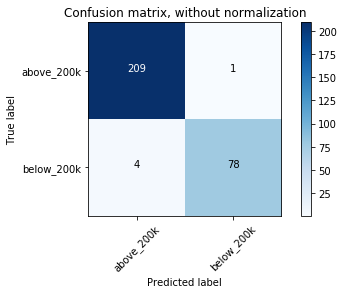

In [147]:
cnf_matrix = metrics.confusion_matrix(y_cls_valid, y_cls_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['above_200k', 'below_200k'],
                      title='Confusion matrix, without normalization')

<a id='section7'></a>
## ** 7. Grid Search/Randomized Search: the quest for hyperparameters ** 
> <img src='https://blogs.sas.com/content/subconsciousmusings/files/2016/09/patricks-hyperparameter-grid-search-smaller2.png' />

#### **Look at how many options are in  logistic regression:**
>        LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
>                  intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
>                 penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
>                  verbose=0, warm_start=False)


Many of the advanced machine learning functions have a large number of model options that can be entered. these are often called **hyper parameters**. These address questions such as: 
- "how long should the model run", or 
- "how many times should my computer re-look at the data" or 
- "how slow should the computer work through the problem?" 

To assist answering some of these questions, `sklearn` has `GridSearch` and `RandomizedSearch` which will try various combinations with a provided model, compare scores and return the optimal model that should be tried.

In [148]:
rfr = RandomForestRegressor(n_jobs=-1)

 #### ** Using GridSearch we can find the optimal parameters for Random forest **

In [149]:
params = {
    'max_features': [0.25, 0.5, 0.7],
    'max_depth' : [ 2,5,10,20]
}
gs = GridSearchCV(cv=5, param_grid=params, estimator=rfr, verbose=0)
gs.fit(X_train,y_train.LogSalePrice.ravel())
print(gs.best_params_, gs.best_score_)

{'max_depth': 10, 'max_features': 0.5} 0.8851199326778889


 #### ** Using RandomSearch we can find the optimal parameters for Random forest **

In [150]:
params = {
    'max_features': [0.25, 0.5, 0.7],
    'max_depth' : [ 2,5,10,20]
}
rs = RandomizedSearchCV(cv=5, param_distributions=params, estimator=rfr, verbose=0)
rs.fit(X_train,y_train.LogSalePrice.ravel())
print(rs.best_params_, rs.best_score_)

{'max_features': 0.25, 'max_depth': 20} 0.8883264691075683


## **Finding the Tree in the Forest - Exploration of Random Forest Results**

This section was moved to an entirely different post, please visit :
https://www.kaggle.com/timolee/finding-trees-through-the-forest-a-rf-dissection

<a id='section8'></a>

# **8. Scores, Loss, and Whats Under the Hood**
<img src='http://2.bp.blogspot.com/-46ThgvQL3lo/UBCmiVWyHtI/AAAAAAAAAAc/tz-Mz62PSjQ/s1600/Low+Score+Judges.jpg' style='width:600px' />

So great, now you have some models. But now what? how do you score them all? lets take a look at some of the ways we can look at the models in hindsight
- **`.coef_`** for linear models these are the coefficients that are assigned to your different features
- **Does coefficient magnitude indicate importance?** Hard to say
- **Did you scale your variables so they are comparable?**  Note from the table below, that the different coefficients aren't a good indicator of importance in this sample case. Since the sample data is not on the same scale, the coefficients can't be compared!

| field | coef | sample data|
|----|-----|-----|
|house_pct_of_land | 100 | 0.03|
|house_price| 20 | 100,0000|

- **Big impact not same as Better predictions** A larger coefficient simple means it has a strong weight in calculating predictions, but that could lead to large error!
- We will talk about better techniques to estimate importance later

In [151]:
print(lm.coef_)
print(rdgCV.coef_)
print(lgm.coef_)

[[-2.52e-12 -8.41e-02  2.08e-02 ...  1.18e-10  5.46e-12  7.64e-02]]
[[ 0.00e+00 -7.24e-03  1.70e-03 ...  1.27e-10  5.89e-12  5.88e-02]]
[[-6.17e-03 -2.94e-03  0.00e+00 ...  6.50e-03  1.32e-10  2.59e-01]]


## **Predictions and scoring regressions (continuous variables)**

<img src='http://www.roperld.com/science/minerals/GasolinePricePrediction.jpg' />

In [152]:
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfr.fit(X_train,y_train)

y_lm_pred = lm.predict(X_train)
y_rdgCV_pred = rdgCV.predict(X_train)
y_rfr_pred = rfr.predict(X_train)

print('-----training score ---')
print(lm.score(X_train, y_train))
print(rdgCV.score(X_train, y_train))
print(rfr.score(X_train, y_train))
print('----Validation score ---')
print(lm.score(X_valid, y_valid))
print(rdgCV.score(X_valid, y_valid))
print(rfr.score(X_valid, y_valid))

C:\Users\Ramesh Pradhan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


-----training score ---
1.0
0.9554931458563823
0.9847166557684051
----Validation score ---
0.7257779312662443
0.73577105360861
0.91332228081051


## **Predictions and Scoring Classifications**

<img src='http://blogs.discovermagazine.com/discoblog/files/2012/04/shutterstock_15484942-e1335545917218.jpg' />
Classification is a bit different than regression. We are trying to predict the class of something, instead of a continuous value. Such as identifying dogs and cats.

When using clasification, or logistic regression, we can always get the predictions  `.predict`(usually 0, 1, 2 or discrete values). But there's a second function all `.predict_logproba` and `.predict_proba` with will give a [0,1] probability for every row. This is often used to rank predictions for classification scores (listed below)

**why log prob vs. prob?** Gradient methods generally work better optimizing logp(x)log⁡p(x) than p(x)p(x) because the gradient of logp(x)log⁡p(x) is generally more well-scaled. That is, it has a size that consistently and helpfully reflects the objective function's geometry, making it easier to select an appropriate step size and get to the optimum in fewer steps.

- **`.predict`** - gives 1's and 0's
- **`.predict_logproba`** - gives array of log probabilities, obs vs. classes
- **`.predict_proba`** - gives array of probabilities, obs vs. classes

In [153]:
y_cls_train['above_200k'].values

array([0., 0., 0., ..., 0., 0., 1.])

In [165]:
y_lgm_p = lgm.predict(X_cls_train)
y_lgm_lpr = lgm.predict_log_proba(X_cls_train)
y_lgm_pr = lgm.predict_proba(X_cls_train)


pd.DataFrame({'true': y_cls_train['above_200k'].values,
              'predict':y_lgm_p, 
              'log_prob_0':y_lgm_lpr[:,0],
              'log_prob_1':y_lgm_lpr[:,1],
              'prob_0': y_lgm_pr[:,0],
              'prob_1': y_lgm_pr[:,1]
             }).head(20)

,true,predict,log_prob_0,log_prob_1,prob_0,prob_1
0,0.0,0.0,-0.000523,-7.556360,0.999477,0.000523
1,0.0,0.0,-0.018159,-4.017642,0.982005,0.017995
2,0.0,0.0,-0.018538,-3.997172,0.981632,0.018368
3,0.0,0.0,-0.003144,-5.763923,0.996861,0.003139
4,0.0,0.0,-0.080744,-2.556572,0.922430,0.077570
5,0.0,0.0,-0.000741,-7.207922,0.999259,0.000741
6,0.0,0.0,-0.131450,-2.094135,0.876823,0.123177
7,0.0,0.0,-0.021498,-3.850531,0.978732,0.021268
8,1.0,1.0,-2.255108,-0.110778,0.104862,0.895138
9,0.0,0.0,-0.129273,-2.109769,0.878734,0.121266


In [164]:
y_lgm_lpr

array([[-5.23e-04, -7.56e+00],
       [-1.82e-02, -4.02e+00],
       [-1.85e-02, -4.00e+00],
       ...,
       [-5.25e-03, -5.25e+00],
       [-5.70e-05, -9.77e+00],
       [-4.65e+00, -9.57e-03]])

# **A Short Explanation of Loss**
<img src='https://iwellnesslife.com/wp-content/uploads/2016/06/omg.jpg' style='width:400px' />

## ** Continuous**

**1. Mean Squared Error (MSE) L2 loss: minimizes the mean ** this is the most common loss for continous variables. It calculates the delta between prediction and actual and gets the squared average.  

**2. Mean Absolute Error (MAE) L1 loss: minimizes the mean ** this is the most common loss for continous variables. It calculates the delta between prediction and actual and gets the absolute average.  

**3. Quantile ** this is not normally implemented in machine learning, but instead of looking at absolute error, it looks at that rank error. In a race, MSE /MAE would care that the leader is 500ft ahead, but Quantile would only care that the runner is first.

## **Classification**

**4.  Log Loss AKA cross entropy loss**
Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0

<img src='http://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png' style='width:400px' />


**5. ROC - AUC - (Receiver Operating Characteristic) AUC - area under the curve ** This curve is plotting True Positve Rate against the False Positive Rate. The idea is for the line to hug the upper left hand corner. An english way of understanding this chart is "what % of bad predictions do I have to accept (x-axis) to get maximum coverage of the true populate (y-axis) 
<img src='http://www.chioka.in/wp-content/uploads/2014/04/sample-ROC-curve.png' />

**6. PR - AUC (precision - recall curve)** The idea curve is for the line to be in the uppe right hand corner. First some definitions:
- Precision: when you guess true, how often are you right?
- Recall: how many of true cases did you guess correctly out of all trues.
<img src='http://www.chioka.in/wp-content/uploads/2014/04/sample-PR-curve.png' />


** 7. Hinge : maximum-margin classification** - this is mainly used for SVM classifiers. 

** 8. Gini Coefficient ** pplies to binary classification and requires a classifier that can in some way rank examples according to the likelihood of being in a positive class.
<img src='https://staesthetic.files.wordpress.com/2014/04/gini-calculation.png' style='width:400px' />

## **Sklearn metrics - good ones to know**

<img src='https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAAyxAAAAJDM5NmViNWQ3LTUxOTItNDg3Ny1hMjViLWNkZWI5ZWY5MGVkMQ.jpg' style='width:400px'/>

- **`metrics.accuracy_score(y_true, y_pred[, …])`**	Accuracy classification score.
- **`metrics.auc(x, y[, reorder])`**	Compute Area Under the Curve (AUC) using the trapezoidal rule
- **`metrics.classification_report(y_true, y_pred)`**	Build a text report showing the main classification metrics
- **`metrics.confusion_matrix(y_true, y_pred[, …])`**	Compute confusion matrix to evaluate the accuracy of a classification
- **`metrics.f1_score(y_true, y_pred[, labels, …])`**	Compute the F1 score, also known as balanced F-score or F-measure
- **`metrics.fbeta_score(y_true, y_pred, beta[, …])`**	Compute the F-beta score
- **`metrics.hinge_loss(y_true, pred_decision[, …])`**	Average hinge loss (non-regularized)
- **`metrics.log_loss(y_true, y_pred[, eps, …])`**	Log loss, aka logistic loss or cross-entropy loss.
- **`metrics.precision_recall_curve(y_true, …)`**	Compute precision-recall pairs for different probability thresholds
- **`metrics.precision_recall_fscore_support(…)`**	Compute precision, recall, F-measure and support for each class
- **`metrics.precision_score(y_true, y_pred[, …])`**	Compute the precision
- **`metrics.recall_score(y_true, y_pred[, …])`**	Compute the recall
- **`metrics.roc_auc_score(y_true, y_score[, …])`**	Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
- **`metrics.roc_curve(y_true, y_score[, …])`**	Compute Receiver operating characteristic (ROC)
- **`metrics.zero_one_loss(y_true, y_pred[, …])`**	Zero-one classification loss.



In [171]:
from sklearn.metrics import accuracy_score, auc, classification_report, \
confusion_matrix, f1_score, log_loss, precision_recall_curve, roc_auc_score, roc_curve

print('Log Loss: ', log_loss(y_lgm_p, y_cls_train))
print('Accuracy_score: ', accuracy_score(y_lgm_p, y_cls_train))
print('\nconfusion_matrix: \n', confusion_matrix(y_lgm_p, y_cls_train))
print('\nClassification_Report: \n', classification_report(y_lgm_p, y_cls_train))

Log Loss:  0.11828416539133056
Accuracy_score:  0.9965753424657534

confusion_matrix: 
 [[820   1]
 [  3 344]]

Classification_Report: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       821
        1.0       1.00      0.99      0.99       347

avg / total       1.00      1.00      1.00      1168

